In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, roc_curve, roc_auc_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import boxcox
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier

data_1 = pd.read_csv('portfolio.csv')
data_2 = pd.read_csv('profile.csv')
data_3 = pd.read_csv('transcript.csv')

# Check if a variable is a DataFrame
def is_dataframe(variable):
    return isinstance(variable, pd.DataFrame)
print(data_1['duration'].nunique())

#Data Checks
print(data_2['id'].nunique())
print(data_3['person'].nunique())
print(data_2['id'].equals(data_3['person']))

data_1.describe()
print(data_1.nunique())

data_2.head()
data_2.describe()
data_2['id'].isin(data_3['person']).value_counts()

data_3.head()
data_3.describe()
print(data_3.nunique())


5
17000
17000
False
Unnamed: 0    10
reward         5
channels       4
difficulty     5
duration       5
offer_type     3
id            10
dtype: int64
Unnamed: 0    306534
person         17000
event              4
value           5121
time             120
dtype: int64


In [4]:
#Adjusting Data
data_3.rename(columns={'person':'id'}, inplace=True)
df_merged_2 = data_2.merge(data_3)
data_2_ad = data_2.drop(columns = ['Unnamed: 0'])
data_3_ad = data_3.drop(columns=['Unnamed: 0'])
data_1_ad = data_1.drop(columns = ['Unnamed: 0'])
data_1_ad.rename(columns={'id':'value'}, inplace=True)

#Merging Datasets
df_merged  = pd.merge(data_2_ad, data_3_ad, on='id')

def extract_offer_id_or_amount(value):
    try:
        value_dict = ast.literal_eval(value)
        # Correctly check for both 'offer id' and 'offer_id'
        if 'offer id' in value_dict:
            return 'offer_id', value_dict['offer id']
        elif 'offer_id' in value_dict:
            return 'offer_id', value_dict['offer_id']
        elif 'amount' in value_dict:
            return 'amount', value_dict['amount']
        else:
            return np.nan, np.nan
    except:
        return np.nan, np.nan

# Assuming 'value' was a typo and should be 'values'
# Apply the function to the 'values' column and unpack the results
df_merged['type'], df_merged['extracted_value'] = zip(*df_merged['value'].apply(extract_offer_id_or_amount))

# Drop the 'value' column
df_merged.drop(columns=['value'], inplace=True)
print(is_dataframe(df_merged))
attempt_df_merged = df_merged.copy()
#print(is_dataframe(attempt_df_merged))

True


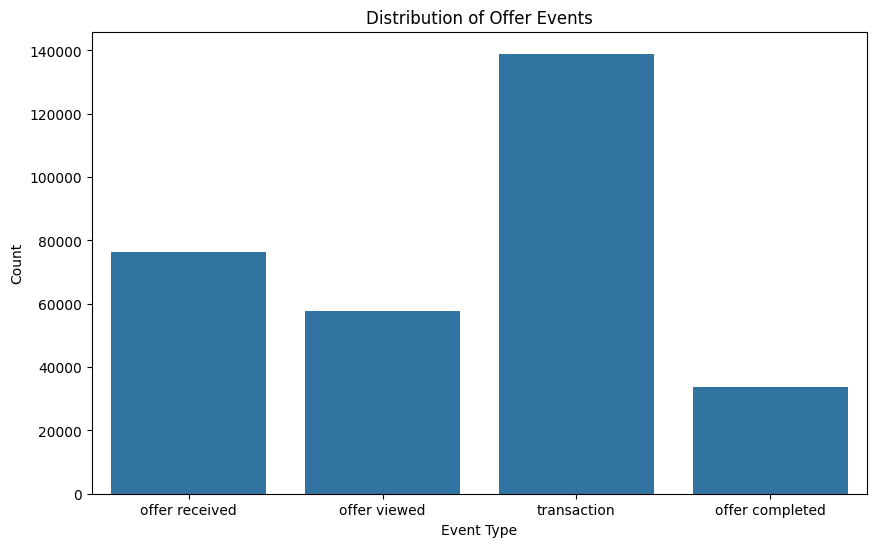

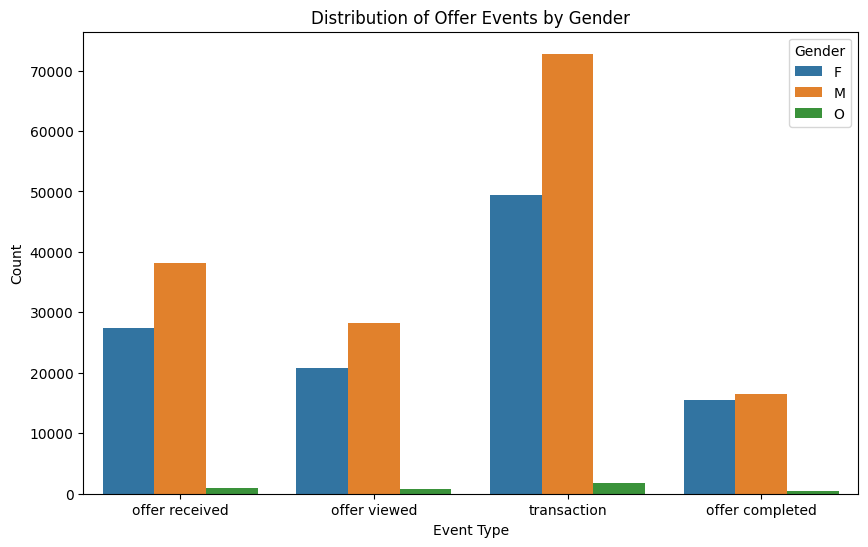

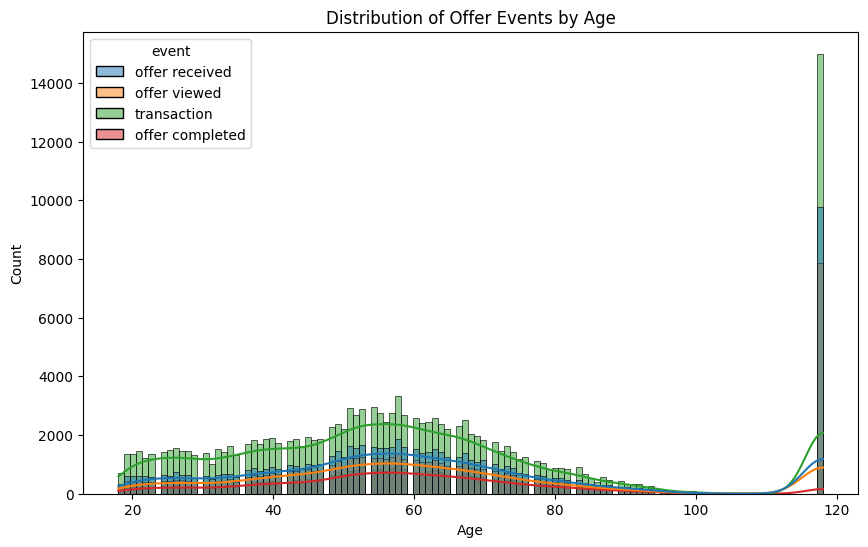

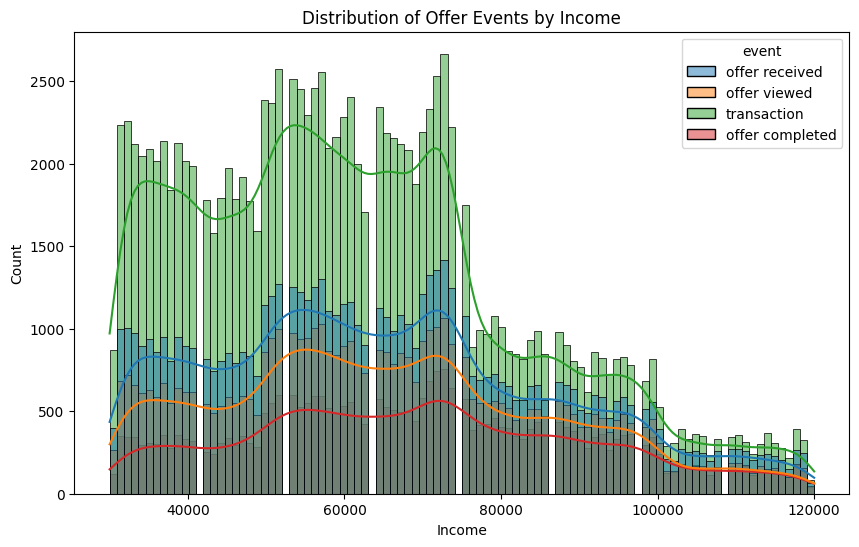

In [5]:
# Distribution of 'offer_received' and 'offer_viewed' events
plt.figure(figsize=(10, 6))
sns.countplot(data=df_merged, x='event')
plt.title('Distribution of Offer Events')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

# Relationship between offer events and gender
plt.figure(figsize=(10, 6))
sns.countplot(data=df_merged, x='event', hue='gender')
plt.title('Distribution of Offer Events by Gender')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

# Relationship between offer events and age
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='age', hue='event', kde=True)
plt.title('Distribution of Offer Events by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Relationship between offer events and income
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='income', hue='event', kde=True)
plt.title('Distribution of Offer Events by Income')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

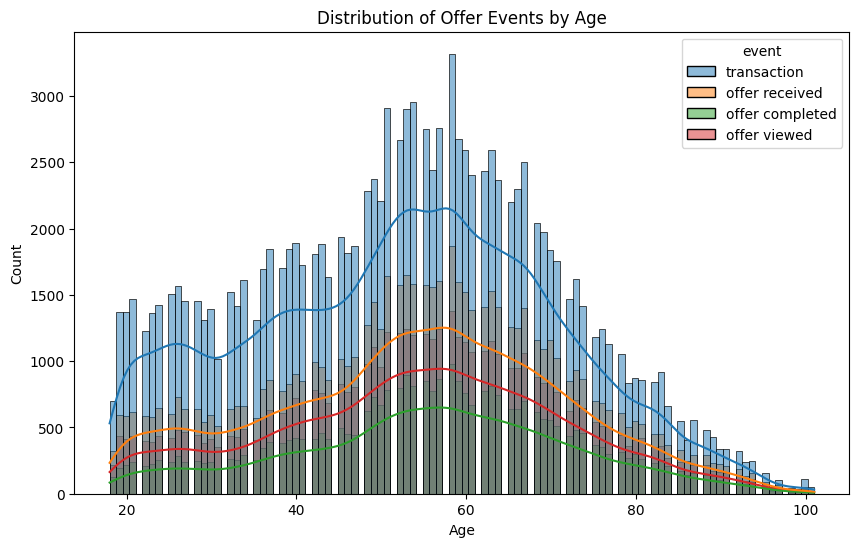

In [6]:
df_merged = df_merged[df_merged['age'] != 118]

# Relationship between offer events and age
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='age', hue='event', kde=True)
plt.title('Distribution of Offer Events by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

df_merged = df_merged.rename(columns={'extracted_value': 'value'})

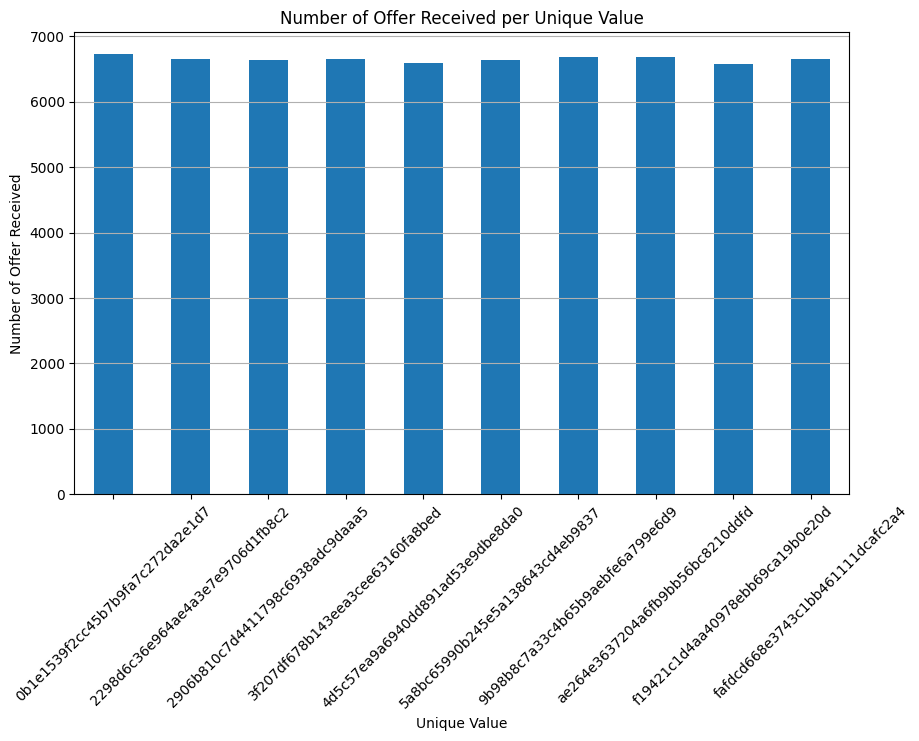

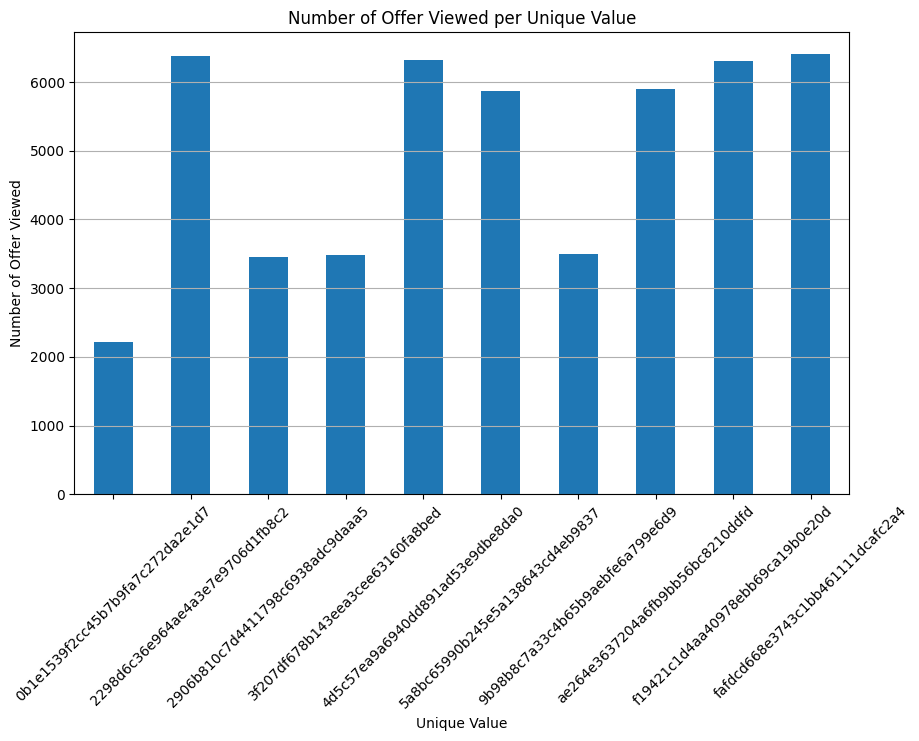

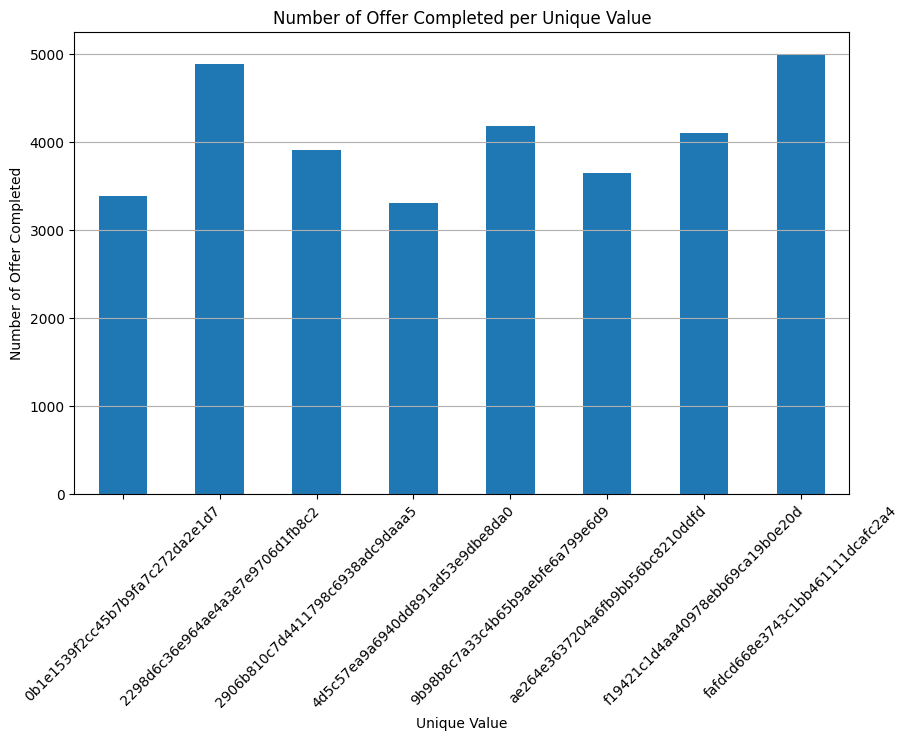

In [7]:
# Filter the DataFrame to get only offer received events
offer_received = df_merged[df_merged['event'] == 'offer received'].copy()

# Count the number of offer received events per unique value
offer_received_counts = offer_received['value'].value_counts()

# Sort the counts in ascending order
offer_received_counts = offer_received_counts.sort_index()

# Plotting
plt.figure(figsize=(10, 6))
offer_received_counts.plot(kind='bar')
plt.title('Number of Offer Received per Unique Value')
plt.xlabel('Unique Value')
plt.ylabel('Number of Offer Received')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Filter the DataFrame to get only offer viewed events
offer_viewed = df_merged[df_merged['event'] == 'offer viewed'].copy()

# Count the number of offer viewed events per unique value
offer_viewed_counts = offer_viewed['value'].value_counts()

# Sort the counts in ascending order
offer_viewed_counts = offer_viewed_counts.sort_index()

# Plotting
plt.figure(figsize=(10, 6))
offer_viewed_counts.plot(kind='bar')
plt.title('Number of Offer Viewed per Unique Value')
plt.xlabel('Unique Value')
plt.ylabel('Number of Offer Viewed')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Filter the DataFrame to get only offer viewed events
offer_completed = df_merged[df_merged['event'] == 'offer completed'].copy()

# Count the number of offer viewed events per unique value
offer_completed_counts = offer_completed['value'].value_counts()

# Sort the counts in ascending order
offer_completed_counts = offer_completed_counts.sort_index()

# Plotting
plt.figure(figsize=(10, 6))
offer_completed_counts.plot(kind='bar')
plt.title('Number of Offer Completed per Unique Value')
plt.xlabel('Unique Value')
plt.ylabel('Number of Offer Completed')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

df_merged_3  = pd.merge(df_merged, data_1_ad, on='value', how='left')

In [8]:
#Data should have the same mean & variance for RFM Scores
filtered_amount_transactions = df_merged_3[df_merged_3['event'] == 'transaction']
filtered_amount_completed = df_merged_3[df_merged_3['event'] == 'offer completed']

#Recency
latest_transaction = filtered_amount_transactions.groupby('id')['time'].max()
latest_order_completed = filtered_amount_completed.groupby('id')['time'].max()

#Frequency
num_of_transactions = filtered_amount_transactions.groupby('id')['time'].size()
num_of_orders_completed = filtered_amount_completed.groupby('id')['time'].size()

#Monetary
size_of_transactions = filtered_amount_transactions.groupby('id')['value'].sum()
size_of_orders_completed = filtered_amount_completed.groupby('id')['value'].sum()
size_of_transactions_float = size_of_transactions.astype(float)

In [9]:
# Print number of NA values for size_of_transactions
print("Number of NA values in 'size_of_transactions':", size_of_transactions.isna().sum())

# Print number of NA values for num_of_transactions
print("Number of NA values in 'num_of_transactions':", num_of_transactions.isna().sum())

# Print number of NA values for latest_transaction
print("Number of NA values in 'latest_transaction':", latest_transaction.isna().sum())

# Print number of NA values for size_of_orders_completed
print("Number of NA values in 'size_of_orders_completed':", size_of_orders_completed.isna().sum())

# Print number of NA values for num_of_orders_completed
print("Number of NA values in 'num_of_orders_completed':", num_of_orders_completed.isna().sum())

# Print number of NA values for latest_order_completed
print("Number of NA values in 'latest_order_completed':", latest_order_completed.isna().sum())

Number of NA values in 'size_of_transactions': 0
Number of NA values in 'num_of_transactions': 0
Number of NA values in 'latest_transaction': 0
Number of NA values in 'size_of_orders_completed': 0
Number of NA values in 'num_of_orders_completed': 0
Number of NA values in 'latest_order_completed': 0


In [10]:
nan_values = size_of_transactions[size_of_transactions.isna()]
print("Number of NaN values in 'size_of_transactions':", len(nan_values))

unique_values = size_of_transactions.unique()
print("Unique values in 'size_of_transactions':", unique_values)

Number of NaN values in 'size_of_transactions': 0
Unique values in 'size_of_transactions': [127.6 79.46000000000001 196.86 ... 12.149999999999999 88.83000000000001
 226.07]


In [11]:
# Apply Min-Max Scaling
min_max_scaler = MinMaxScaler()

# Scaling for Recency
scaled_latest_transaction_minmax = min_max_scaler.fit_transform(latest_transaction.values.reshape(-1, 1))
scaled_latest_order_completed_minmax = min_max_scaler.fit_transform(latest_order_completed.values.reshape(-1, 1))

# Scaling for Frequency
scaled_num_transactions_minmax = min_max_scaler.fit_transform(num_of_transactions.values.reshape(-1, 1))
scaled_num_orders_completed_minmax = min_max_scaler.fit_transform(num_of_orders_completed.values.reshape(-1, 1))

# Scaling for Monetary
scaled_size_of_transactions_minmax = min_max_scaler.fit_transform(size_of_transactions.values.reshape(-1, 1))

# Apply Log Transformation
scaled_latest_transaction_log = np.log(latest_transaction.values.reshape(-1, 1) + 1)  # Adding 1 to avoid log(0)
scaled_latest_order_completed_log = np.log(latest_order_completed.values.reshape(-1, 1) + 1)

scaled_num_transactions_log = np.log(num_of_transactions.values.reshape(-1, 1) + 1)  # Adding 1 to avoid log(0)
scaled_num_orders_completed_log = np.log(num_of_orders_completed.values.reshape(-1, 1) + 1)
scaled_size_of_transactions_log = np.log(size_of_transactions_float.values.reshape(-1, 1) + 1)  # Adding 1 to avoid log(0)

# Apply Power Transformation (Box-Cox Transformation)
scaled_latest_transaction_boxcox, _ = boxcox(latest_transaction.values + 1)  # Adding 1 to avoid log(0)
scaled_latest_order_completed_boxcox, _ = boxcox(latest_order_completed.values + 1)

scaled_num_transactions_boxcox, _ = boxcox(num_of_transactions.values + 1)  # Adding 1 to avoid log(0)
scaled_num_orders_completed_boxcox, _ = boxcox(num_of_orders_completed.values + 1)
scaled_size_of_transactions_boxcox, _ = boxcox(size_of_transactions_float.values + 1)  # Adding 1 to avoid log(0)

# Create dataframes for scaled metrics
scaled_recency_minmax_transaction = pd.DataFrame({
    'id': latest_transaction.index,
    'scaled_latest_transaction_minmax': scaled_latest_transaction_minmax.flatten()
})

scaled_recency_minmax_order_completed = pd.DataFrame({
    'id': latest_order_completed.index,
    'scaled_latest_order_completed_minmax': scaled_latest_order_completed_minmax.flatten()
})

scaled_recency_log_transaction = pd.DataFrame({
    'id': latest_transaction.index,
    'scaled_latest_transaction_log': scaled_latest_transaction_log.flatten()
})

scaled_recency_log_order_completed = pd.DataFrame({
    'id': latest_order_completed.index,
    'scaled_latest_order_completed_log': scaled_latest_order_completed_log.flatten()
})

scaled_recency_boxcox_transaction = pd.DataFrame({
    'id': latest_transaction.index,
    'scaled_latest_transaction_boxcox': scaled_latest_transaction_boxcox.flatten()
})

scaled_recency_boxcox_order_completed = pd.DataFrame({
    'id': latest_order_completed.index,
    'scaled_latest_order_completed_boxcox': scaled_latest_order_completed_boxcox.flatten()
})

scaled_frequency_minmax_transactions = pd.DataFrame({
    'id': num_of_transactions.index,
    'scaled_num_transactions_minmax': scaled_num_transactions_minmax.flatten()
})

scaled_frequency_minmax_orders_completed = pd.DataFrame({
    'id': num_of_orders_completed.index,
    'scaled_num_orders_completed_minmax': scaled_num_orders_completed_minmax.flatten()
})

scaled_frequency_log_transactions = pd.DataFrame({
    'id': num_of_transactions.index,
    'scaled_num_transactions_log': scaled_num_transactions_log.flatten()
})

scaled_frequency_log_orders_completed = pd.DataFrame({
    'id': num_of_orders_completed.index,
    'scaled_num_orders_completed_log': scaled_num_orders_completed_log.flatten()
})

scaled_frequency_boxcox_transactions = pd.DataFrame({
    'id': num_of_transactions.index,
    'scaled_num_transactions_boxcox': scaled_num_transactions_boxcox.flatten()
})

scaled_frequency_boxcox_orders_completed = pd.DataFrame({
    'id': num_of_orders_completed.index,
    'scaled_num_orders_completed_boxcox': scaled_num_orders_completed_boxcox.flatten()
})

# Create dataframes for scaled monetary metrics
scaled_monetary_minmax_transactions = pd.DataFrame({
    'id': size_of_transactions.index,
    'scaled_size_of_transactions_minmax': scaled_size_of_transactions_minmax.flatten()
})


scaled_monetary_log_transactions = pd.DataFrame({
    'id': size_of_transactions.index,
    'scaled_size_of_transactions_log': scaled_size_of_transactions_log.flatten()
})


scaled_monetary_boxcox_transactions = pd.DataFrame({
    'id': size_of_transactions.index,
    'scaled_size_of_transactions_boxcox': scaled_size_of_transactions_boxcox.flatten()
})
#If statement so when rerunning code, doesn't create brand new columns everytime. If log of monetary scaling is removed, needs to be adjusted.
if 'scaled_size_of_transactions_log' not in df_merged_3.columns:
    # Merge the scaled monetary dataframes with df_merged_3
    df_merged_3 = pd.merge(df_merged_3, scaled_monetary_minmax_transactions, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_monetary_log_transactions, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_monetary_boxcox_transactions, on='id', how='left')

    # Merge the scaled frequency and recency dataframes with df_merged_3
    df_merged_3 = pd.merge(df_merged_3, scaled_recency_minmax_transaction, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_recency_minmax_order_completed, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_recency_log_transaction, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_recency_log_order_completed, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_recency_boxcox_transaction, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_recency_boxcox_order_completed, on='id', how='left')

    df_merged_3 = pd.merge(df_merged_3, scaled_frequency_minmax_transactions, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_frequency_minmax_orders_completed, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_frequency_log_transactions, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_frequency_log_orders_completed, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_frequency_boxcox_transactions, on='id', how='left')
    df_merged_3 = pd.merge(df_merged_3, scaled_frequency_boxcox_orders_completed, on='id', how='left')
else: 
    print("The column's have already been added")



In [12]:
# Check for duplicate rows
duplicate_rows = df_merged_3[df_merged_3.duplicated()]

# Print the number of duplicate rows
print("Number of duplicate rows:", duplicate_rows.shape[0])

# Create a new DataFrame with unique individuals
df_merged_3_unique_individuals = df_merged_3.drop_duplicates(subset=['id'])

# Print the shape of the new DataFrame
print("Shape of DataFrame with unique individuals:", df_merged_3_unique_individuals.shape)

Number of duplicate rows: 374
Shape of DataFrame with unique individuals: (14825, 29)


In [13]:
#Various column options
min_max_transactions_columns = df_merged_3_unique_individuals[['scaled_size_of_transactions_minmax','scaled_num_transactions_minmax','scaled_latest_transaction_minmax']]
boxcox_transactions_columns = df_merged_3_unique_individuals[['scaled_size_of_transactions_boxcox','scaled_num_transactions_boxcox','scaled_latest_transaction_boxcox']]
log_transactions_columns = df_merged_3_unique_individuals[['scaled_size_of_transactions_log','scaled_num_transactions_log','scaled_latest_transaction_log']]

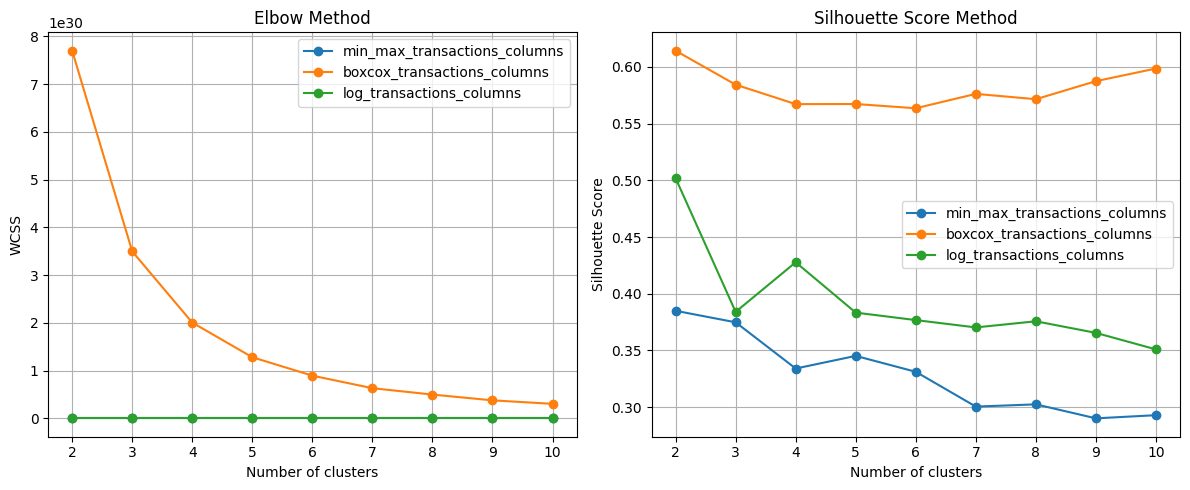

In [14]:
# Define column options
column_options = [
    ('min_max_transactions_columns', min_max_transactions_columns),
    ('boxcox_transactions_columns', boxcox_transactions_columns),
    ('log_transactions_columns', log_transactions_columns)
]

# Elbow Method to find the optimal number of clusters
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax in axes:
    ax.grid(True)

for method_name, columns in column_options:
    wcss = []
    silhouette_scores = []
    
    # Drop rows with NaNs
    columns_no_na = columns.dropna()
    
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(columns_no_na)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(columns_no_na, kmeans.labels_))
    
    # Plotting WCSS
    axes[0].plot(range(2, 11), wcss, marker='o', linestyle='-', label=method_name)
    axes[0].set_title('Elbow Method')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('WCSS')  # Within-cluster sum of squares

    # Plotting Silhouette Scores
    axes[1].plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', label=method_name)
    axes[1].set_title('Silhouette Score Method')
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Silhouette Score')

# Add legends
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

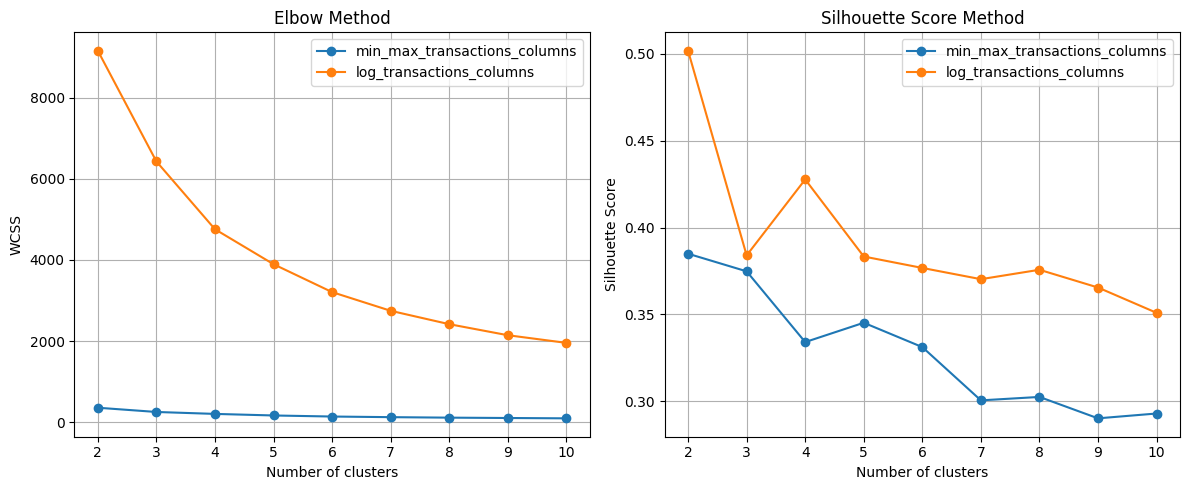

In [15]:
# Define column options
column_options = [
    ('min_max_transactions_columns', min_max_transactions_columns),
    ('log_transactions_columns', log_transactions_columns)
]

# Elbow Method to find the optimal number of clusters
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax in axes:
    ax.grid(True)

for method_name, columns in column_options:
    wcss = []
    silhouette_scores = []
    
    # Drop rows with NaNs
    columns_no_na = columns.dropna()
    
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(columns_no_na)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(columns_no_na, kmeans.labels_))
    
    # Plotting WCSS
    axes[0].plot(range(2, 11), wcss, marker='o', linestyle='-', label=method_name)
    axes[0].set_title('Elbow Method')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('WCSS')  # Within-cluster sum of squares

    # Plotting Silhouette Scores
    axes[1].plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', label=method_name)
    axes[1].set_title('Silhouette Score Method')
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Silhouette Score')

# Add legends
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

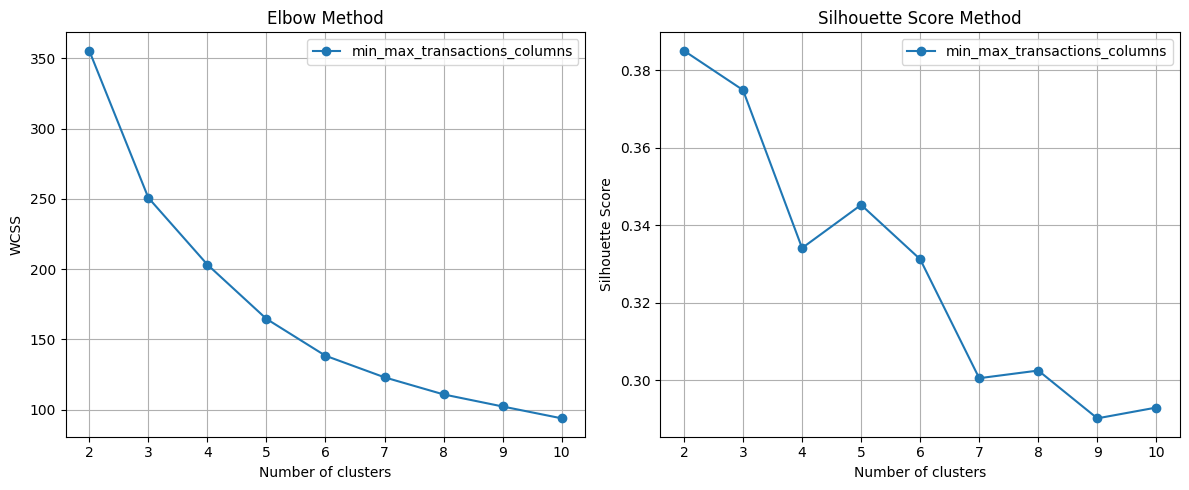

In [16]:

# Define column options
column_options = [
    ('min_max_transactions_columns', min_max_transactions_columns)
]

# Elbow Method to find the optimal number of clusters
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax in axes:
    ax.grid(True)

for method_name, columns in column_options:
    wcss = []
    silhouette_scores = []
    
    # Drop rows with NaNs
    columns_no_na = columns.dropna()
    
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(columns_no_na)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(columns_no_na, kmeans.labels_))
    
    # Plotting WCSS
    axes[0].plot(range(2, 11), wcss, marker='o', linestyle='-', label=method_name)
    axes[0].set_title('Elbow Method')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('WCSS')  # Within-cluster sum of squares

    # Plotting Silhouette Scores
    axes[1].plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', label=method_name)
    axes[1].set_title('Silhouette Score Method')
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Silhouette Score')

# Add legends
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

C:\Users\abdif\AppData\Local\Temp\ipykernel_15064\349275663.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_max_transactions_columns.dropna(inplace=True)
C:\Users\abdif\AppData\Local\Temp\ipykernel_15064\349275663.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_max_transactions_columns['Cluster'] = cluster_labels


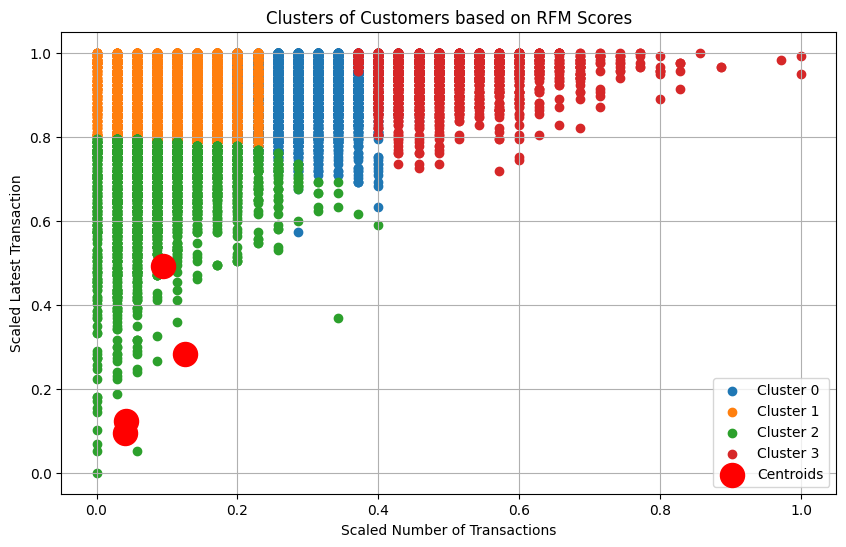

In [17]:


# Select the optimal number of clusters
num_clusters = 4

# Drop rows with NaN values
min_max_transactions_columns.dropna(inplace=True)

# Initialize KMeans with the selected number of clusters
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fit KMeans to the data
kmeans.fit(min_max_transactions_columns)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the dataframe
min_max_transactions_columns['Cluster'] = cluster_labels

# Plotting the clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_data = min_max_transactions_columns[min_max_transactions_columns['Cluster'] == i]
    plt.scatter(cluster_data['scaled_num_transactions_minmax'], 
                cluster_data['scaled_latest_transaction_minmax'], 
                label=f'Cluster {i}')

# Plotting the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('Clusters of Customers based on RFM Scores')
plt.xlabel('Scaled Number of Transactions')
plt.ylabel('Scaled Latest Transaction')
plt.legend()
plt.grid(True)
plt.show()

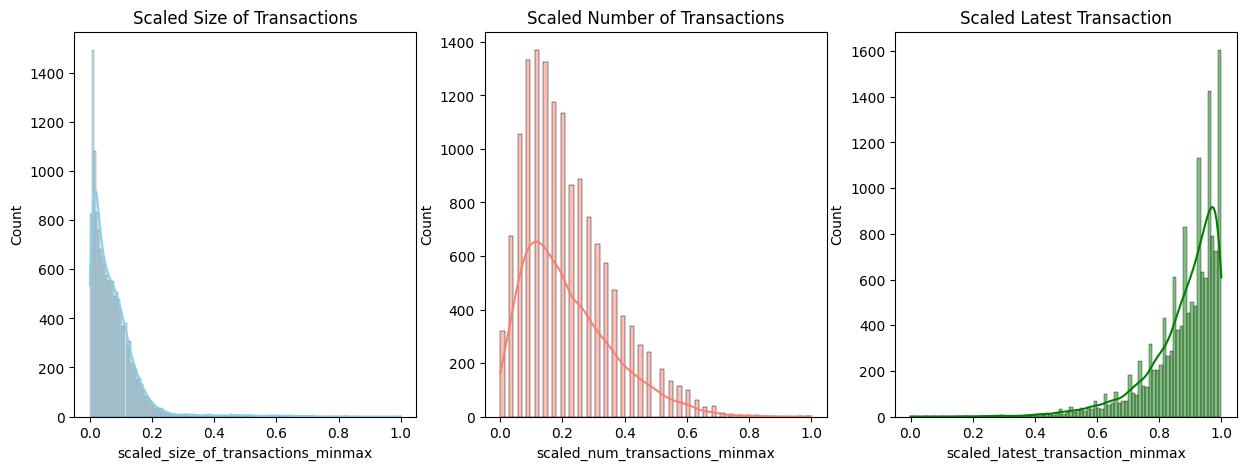

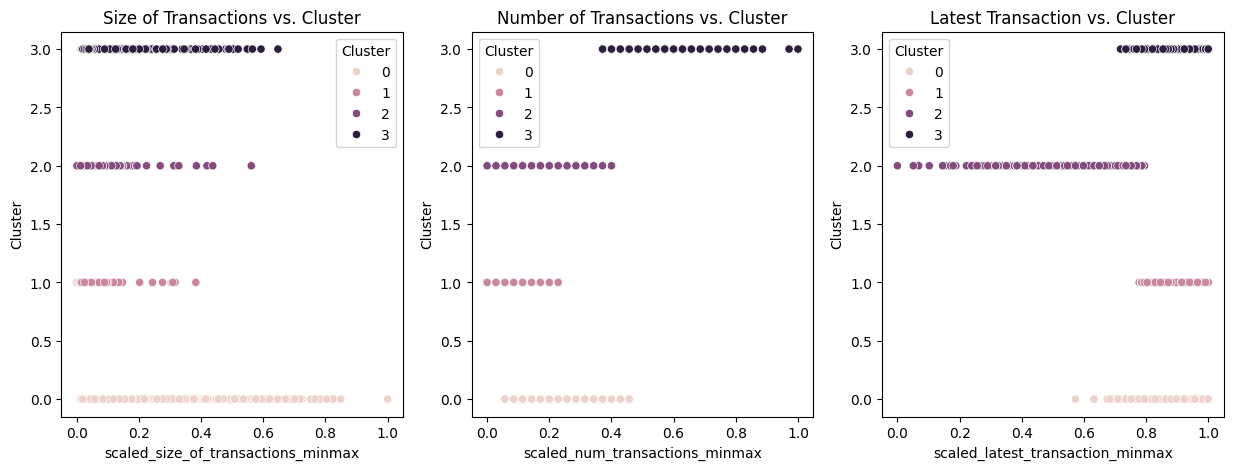

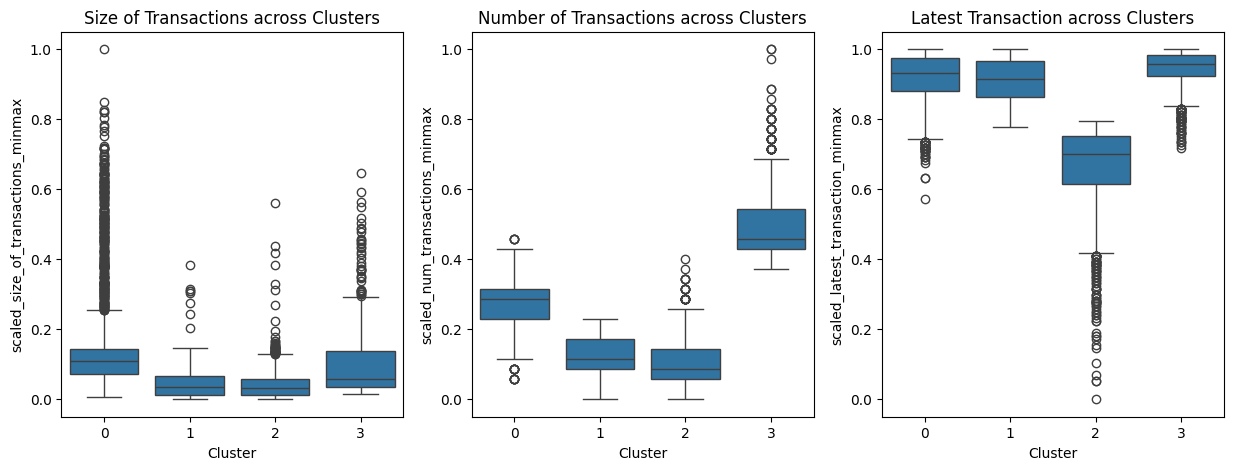

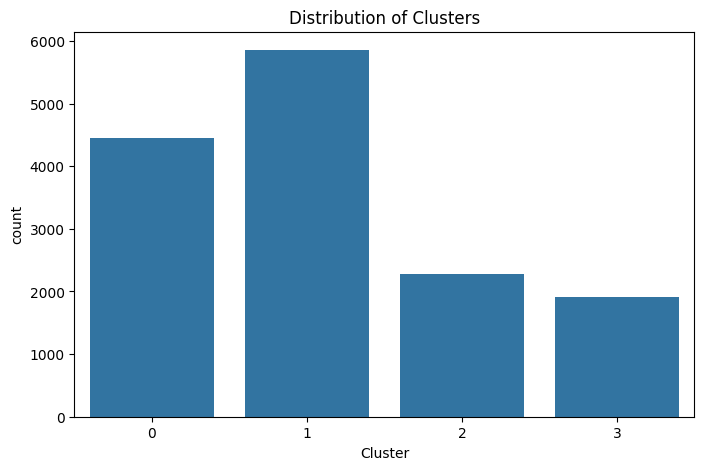

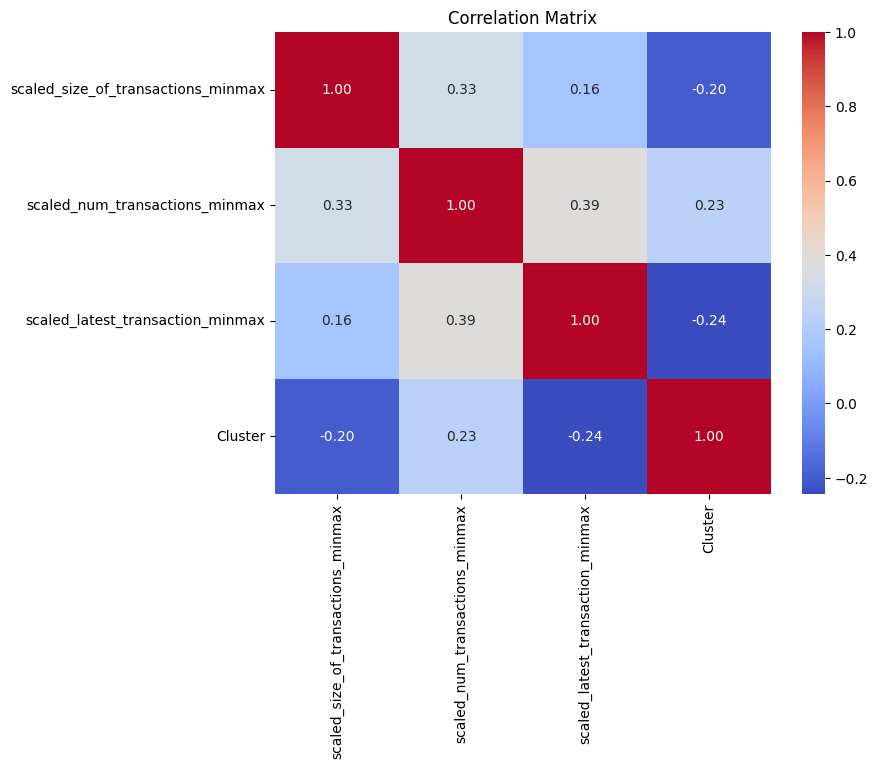

In [18]:
# Univariate Analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(min_max_transactions_columns['scaled_size_of_transactions_minmax'], kde=True, color='skyblue')
plt.title('Scaled Size of Transactions')

plt.subplot(1, 3, 2)
sns.histplot(min_max_transactions_columns['scaled_num_transactions_minmax'], kde=True, color='salmon')
plt.title('Scaled Number of Transactions')

plt.subplot(1, 3, 3)
sns.histplot(min_max_transactions_columns['scaled_latest_transaction_minmax'], kde=True, color='green')
plt.title('Scaled Latest Transaction')
plt.show()

# Bivariate Analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='scaled_size_of_transactions_minmax', y='Cluster', data=min_max_transactions_columns, hue='Cluster')
plt.title('Size of Transactions vs. Cluster')

plt.subplot(1, 3, 2)
sns.scatterplot(x='scaled_num_transactions_minmax', y='Cluster', data=min_max_transactions_columns, hue='Cluster')
plt.title('Number of Transactions vs. Cluster')

plt.subplot(1, 3, 3)
sns.scatterplot(x='scaled_latest_transaction_minmax', y='Cluster', data=min_max_transactions_columns, hue='Cluster')
plt.title('Latest Transaction vs. Cluster')
plt.show()

# Box plot to compare distributions across clusters
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='scaled_size_of_transactions_minmax', data=min_max_transactions_columns)
plt.title('Size of Transactions across Clusters')

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='scaled_num_transactions_minmax', data=min_max_transactions_columns)
plt.title('Number of Transactions across Clusters')

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='scaled_latest_transaction_minmax', data=min_max_transactions_columns)
plt.title('Latest Transaction across Clusters')
plt.show()

# Cluster Analysis
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=min_max_transactions_columns)
plt.title('Distribution of Clusters')
plt.show()

# Correlation Analysis
correlation_matrix = min_max_transactions_columns[['scaled_size_of_transactions_minmax', 'scaled_num_transactions_minmax', 'scaled_latest_transaction_minmax', 'Cluster']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Merge df_merged_3 with min_max_transactions_columns based on common columns
merged_df_4 = pd.merge(df_merged_3, min_max_transactions_columns, 
                     on=['scaled_size_of_transactions_minmax', 'scaled_num_transactions_minmax', 'scaled_latest_transaction_minmax'], 
                     how='left')

# Drop duplicates to retain only unique rows
merged_df_4 = merged_df_4.drop_duplicates()

In [20]:
# Filter rows where type is offer_id and the event is offer received
offer_df = merged_df_4[(merged_df_4['type'] == 'offer_id') & (merged_df_4['event'] == 'offer received')]

# Filter rows for BOGO, discount, and informational offers
bogo_df = offer_df[offer_df['offer_type'] == 'bogo']
discount_df = offer_df[offer_df['offer_type'] == 'discount']
informational_df = offer_df[offer_df['offer_type'] == 'informational']

# Group by Cluster and count the occurrences for offer received and offer completed for BOGO
bogo_completed = merged_df_4[(merged_df_4['event'] == 'offer completed') & (merged_df_4['offer_type'] == 'bogo')].groupby('Cluster').size()
bogo_received = merged_df_4[(merged_df_4['event'] == 'offer received') & (merged_df_4['offer_type'] == 'bogo')].groupby('Cluster').size()

# Group by Cluster and count the occurrences for offer received and offer completed for discount
discount_completed = merged_df_4[(merged_df_4['event'] == 'offer completed') & (merged_df_4['offer_type'] == 'discount')].groupby('Cluster').size()
discount_received = merged_df_4[(merged_df_4['event'] == 'offer received') & (merged_df_4['offer_type'] == 'discount')].groupby('Cluster').size()

# Group by Cluster and count the occurrences for offer received for informational
informational_received = merged_df_4[(merged_df_4['event'] == 'offer received') & (merged_df_4['offer_type'] == 'informational')].groupby('Cluster').size()

# Count the number of unique customers in each cluster
num_customers_per_cluster = merged_df_4.groupby('Cluster')['id'].nunique()

# Calculate the average number of informational offers received per person in each cluster
avg_info_received_per_person = informational_received / num_customers_per_cluster
informational_viewed = merged_df_4[(merged_df_4['event'] == 'offer viewed') & (merged_df_4['offer_type'] == 'informational')]

Calinski-Harabasz Index: 9327.476771665246


Silhouette Score: 0.33411307734196405
Davies–Bouldin Index: 1.003243263912552


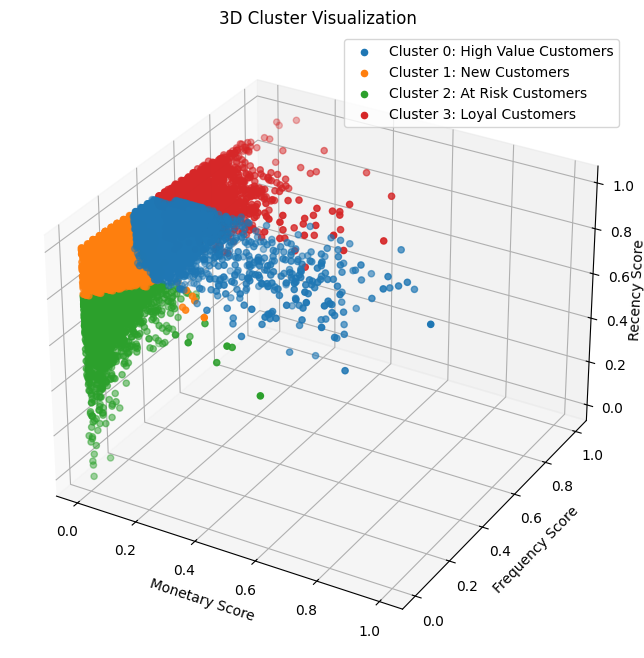

In [21]:
# Define manually assigned cluster labels
class_labels = {
    0: 'Cluster 0: High Value Customers',
    1: 'Cluster 1: New Customers',
    2: 'Cluster 2: At Risk Customers',
    3: 'Cluster 3: Loyal Customers'
}

# Data
X = min_max_transactions_columns[['scaled_size_of_transactions_minmax', 'scaled_num_transactions_minmax', 'scaled_latest_transaction_minmax']]

# Initialize KMeans with the selected number of clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Fit KMeans to the data
kmeans.fit(X)

# Compute Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Compute silhouette score
silhouette = silhouette_score(X, kmeans.labels_)
print(f"Silhouette Score: {silhouette}")

# Compute Davies–Bouldin index
davies_bouldin = davies_bouldin_score(X, kmeans.labels_)
print(f"Davies–Bouldin Index: {davies_bouldin}")

# Plotting the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster in range(num_clusters):
    cluster_data = X[kmeans.labels_ == cluster]
    ax.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], cluster_data.iloc[:, 2], label=class_labels[cluster])

ax.set_xlabel('Monetary Score')
ax.set_ylabel('Frequency Score')
ax.set_zlabel('Recency Score', labelpad=-1)
ax.set_title('3D Cluster Visualization')

plt.legend()
plt.show()

In [22]:
# Merge df_merged_3 with min_max_transactions_columns based on common columns
merged_df_4 = pd.merge(df_merged_3, min_max_transactions_columns, 
                     on=['scaled_size_of_transactions_minmax', 'scaled_num_transactions_minmax', 'scaled_latest_transaction_minmax'], 
                     how='left')

# Drop duplicates to retain only unique rows
merged_df_4 = merged_df_4.drop_duplicates()

In [23]:
# Filter rows where type is offer_id
offer_df = merged_df_4[merged_df_4['type'] == 'offer_id']

# Filter rows for each offer type
offer_received_df = offer_df[offer_df['event'] == 'offer received']
offer_viewed_df = offer_df[offer_df['event'] == 'offer viewed']
offer_completed_df = offer_df[offer_df['event'] == 'offer completed']

# Group by event (offer type) and cluster, and count the occurrences for each offer type
offer_received_analysis = offer_received_df.groupby(['event', 'Cluster']).size().unstack().fillna(0)
offer_viewed_analysis = offer_viewed_df.groupby(['event', 'Cluster']).size().unstack().fillna(0)
offer_completed_analysis = offer_completed_df.groupby(['event', 'Cluster']).size().unstack().fillna(0)

In [24]:
# Filter rows where type is offer_id and the event is offer received
offer_df = merged_df_4[(merged_df_4['type'] == 'offer_id') & (merged_df_4['event'] == 'offer received')]

# Filter rows for BOGO, discount, and informational offers
bogo_df = offer_df[offer_df['offer_type'] == 'bogo']
discount_df = offer_df[offer_df['offer_type'] == 'discount']
informational_df = offer_df[offer_df['offer_type'] == 'informational']

# Group by Cluster and count the occurrences for offer received and offer completed for BOGO
bogo_completed = merged_df_4[(merged_df_4['event'] == 'offer completed') & (merged_df_4['offer_type'] == 'bogo')].groupby('Cluster').size()
bogo_received = merged_df_4[(merged_df_4['event'] == 'offer received') & (merged_df_4['offer_type'] == 'bogo')].groupby('Cluster').size()

# Group by Cluster and count the occurrences for offer received and offer completed for discount
discount_completed = merged_df_4[(merged_df_4['event'] == 'offer completed') & (merged_df_4['offer_type'] == 'discount')].groupby('Cluster').size()
discount_received = merged_df_4[(merged_df_4['event'] == 'offer received') & (merged_df_4['offer_type'] == 'discount')].groupby('Cluster').size()

# Group by Cluster and count the occurrences for offer received for informational
informational_received = merged_df_4[(merged_df_4['event'] == 'offer received') & (merged_df_4['offer_type'] == 'informational')].groupby('Cluster').size()

# Count the number of unique customers in each cluster
num_customers_per_cluster = merged_df_4.groupby('Cluster')['id'].nunique()

# Calculate the average number of informational offers received per person in each cluster
avg_info_received_per_person = informational_received / num_customers_per_cluster
informational_viewed = merged_df_4[(merged_df_4['event'] == 'offer viewed') & (merged_df_4['offer_type'] == 'informational')]

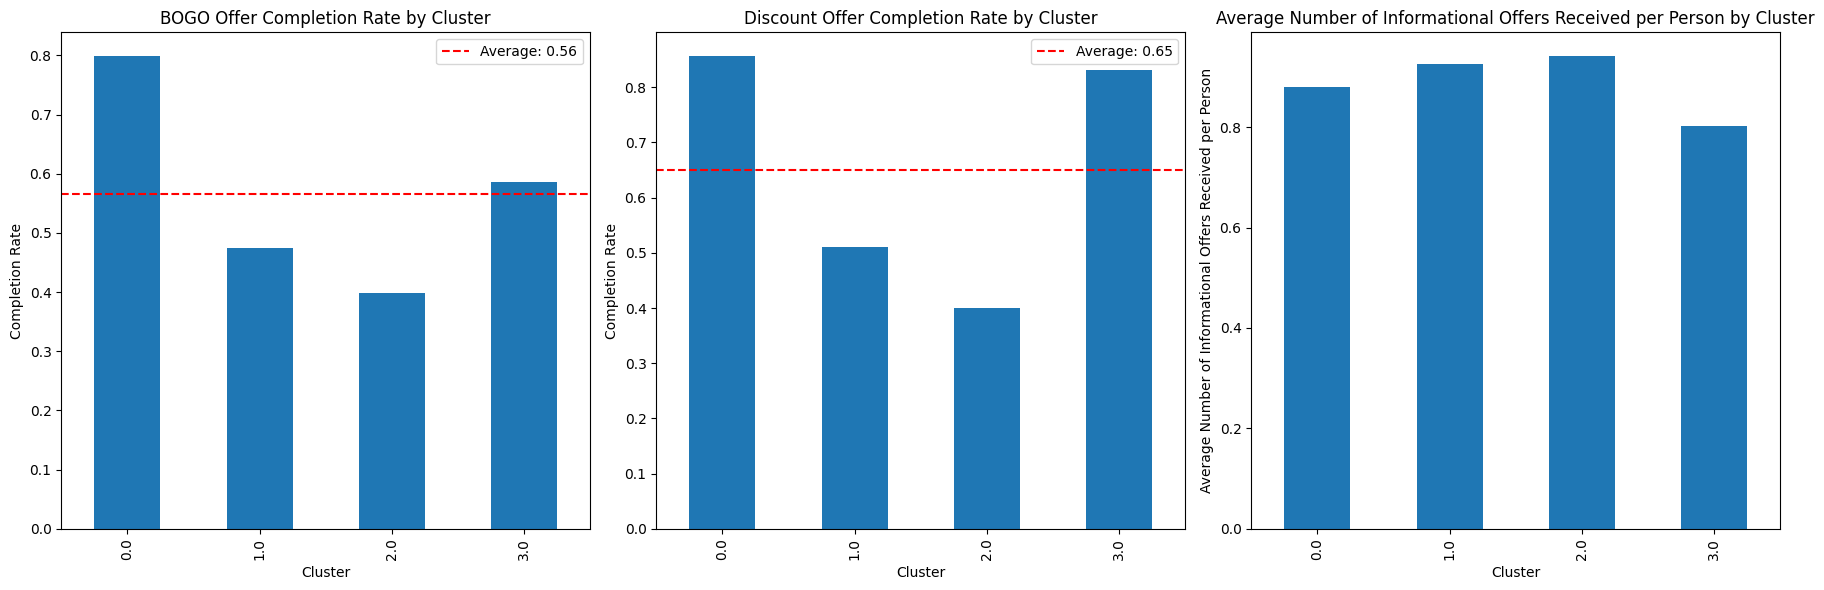

In [25]:
# Calculate completion rate for BOGO and discount offers
bogo_completion_rate = bogo_completed / bogo_received
discount_completion_rate = discount_completed / discount_received

# Calculate average completion rate across all clusters for BOGO and discount offers
avg_bogo_completion_rate = bogo_completion_rate.mean()
avg_discount_completion_rate = discount_completion_rate.mean()

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# BOGO Completion Rate
bogo_completion_rate.plot(kind='bar', ax=axes[0])
axes[0].set_title('BOGO Offer Completion Rate by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Completion Rate')
axes[0].axhline(avg_bogo_completion_rate, color='r', linestyle='--', label=f'Average: {avg_bogo_completion_rate:.2f}')
axes[0].legend()

# Discount Completion Rate
discount_completion_rate.plot(kind='bar', ax=axes[1])
axes[1].set_title('Discount Offer Completion Rate by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Completion Rate')
axes[1].axhline(avg_discount_completion_rate, color='r', linestyle='--', label=f'Average: {avg_discount_completion_rate:.2f}')
axes[1].legend()

# Average Number of Informational Offers Received per Person
avg_info_received_per_person.plot(kind='bar', ax=axes[2])
axes[2].set_title('Average Number of Informational Offers Received per Person by Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Average Number of Informational Offers Received per Person')

plt.tight_layout()
plt.show()

In [26]:
# Count the number of unique customers in each cluster
num_customers_per_cluster = merged_df_4.groupby('Cluster')['id'].nunique()

# Calculate the average number of informational offers received per person in each cluster
avg_info_received_per_person = informational_received / num_customers_per_cluster
informational_viewed = merged_df_4[(merged_df_4['event'] == 'offer viewed') & (merged_df_4['offer_type'] == 'informational')]

# Group by Cluster and count the occurrences for informational offers viewed
informational_viewed_counts = informational_viewed.groupby('Cluster').size()

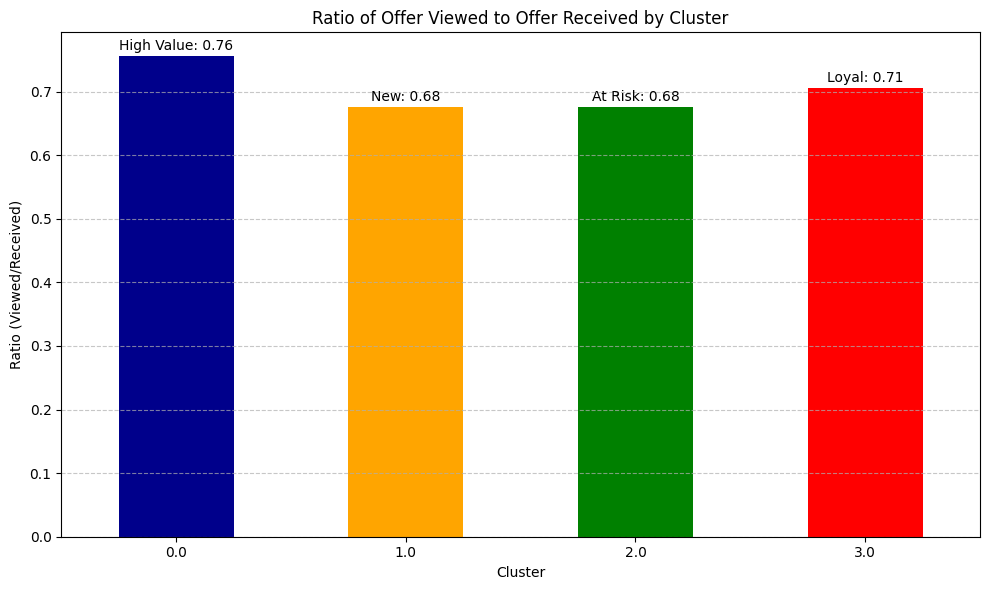

In [27]:
# Filter rows where the event is offer viewed and the offer type is informational
total_informational_viewed = merged_df_4[(merged_df_4['event'] == 'offer viewed') & (merged_df_4['offer_type'] == 'informational')]
total_informational_received = merged_df_4[(merged_df_4['event'] == 'offer received') & (merged_df_4['offer_type'] == 'informational')]

# Define colors for each cluster
cluster_colors = {0: 'darkblue', 1: 'orange', 2: 'green', 3: 'red'}

# Define cluster labels
cluster_labels = {0: 'High Value', 1: 'New', 2: 'At Risk', 3: 'Loyal'}

# Calculate the ratio of offer viewed to offer received for each cluster
ratio_viewed_to_received = total_informational_viewed.groupby('Cluster').size() / total_informational_received.groupby('Cluster').size()

# Plotting
plt.figure(figsize=(10, 6))
ratio_viewed_to_received.plot(kind='bar', color=[cluster_colors[i] for i in ratio_viewed_to_received.index])
plt.title('Ratio of Offer Viewed to Offer Received by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Ratio (Viewed/Received)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate clusters with labels
for i, ratio in enumerate(ratio_viewed_to_received):
    plt.text(i, ratio + 0.01, f'{cluster_labels[i]}: {ratio:.2f}', ha='center')

plt.tight_layout()
plt.show()

In [28]:
# Offer Viewed - BOGO
total_bogo_viewed = df_merged_3[(df_merged_3['event'] == 'offer viewed') & (df_merged_3['offer_type'] == 'bogo')]
total_bogo_viewed_count = total_bogo_viewed.shape[0]
print("Total BOGO Offers Viewed:", total_bogo_viewed_count)

# Offer Received - BOGO
total_bogo_received = df_merged_3[(df_merged_3['event'] == 'offer received') & (df_merged_3['offer_type'] == 'bogo')]
total_bogo_received_count = total_bogo_received.shape[0]
print("Total BOGO Offers Received:", total_bogo_received_count)

# Offer Completed - BOGO
total_bogo_completed = df_merged_3[(df_merged_3['event'] == 'offer completed') & (df_merged_3['offer_type'] == 'bogo')]
total_bogo_completed_count = total_bogo_completed.shape[0]
print("Total BOGO Offers Completed:", total_bogo_completed_count)

# Offer Viewed - Discount
total_discount_viewed = df_merged_3[(df_merged_3['event'] == 'offer viewed') & (df_merged_3['offer_type'] == 'discount')]
total_discount_viewed_count = total_discount_viewed.shape[0]
print("Total Discount Offers Viewed:", total_discount_viewed_count)

# Offer Received - Discount
total_discount_received = df_merged_3[(df_merged_3['event'] == 'offer received') & (df_merged_3['offer_type'] == 'discount')]
total_discount_received_count = total_discount_received.shape[0]
print("Total Discount Offers Received:", total_discount_received_count)

# Offer Completed - Discount
total_discount_completed = df_merged_3[(df_merged_3['event'] == 'offer completed') & (df_merged_3['offer_type'] == 'discount')]
total_discount_completed_count = total_discount_completed.shape[0]
print("Total Discount Offers Completed:", total_discount_completed_count)

# Offer Viewed - Informational
total_informational_viewed = df_merged_3[(df_merged_3['event'] == 'offer viewed') & (df_merged_3['offer_type'] == 'informational')]
total_informational_viewed_count = total_informational_viewed.shape[0]
print("Total Informational Offers Viewed:", total_informational_viewed_count)

# Offer Received - Informational
total_informational_received = df_merged_3[(df_merged_3['event'] == 'offer received') & (df_merged_3['offer_type'] == 'informational')]
total_informational_received_count = total_informational_received.shape[0]
print("Total Informational Offers Received:", total_informational_received_count)

# Offer Completed - Informational
total_informational_completed = df_merged_3[(df_merged_3['event'] == 'offer completed') & (df_merged_3['offer_type'] == 'informational')]
total_informational_completed_count = total_informational_completed.shape[0]
print("Total Informational Offers Completed:", total_informational_completed_count)

Total BOGO Offers Viewed: 22039
Total BOGO Offers Received: 26537
Total BOGO Offers Completed: 15258
Total Discount Offers Viewed: 18461
Total Discount Offers Received: 26664
Total Discount Offers Completed: 17186
Total Informational Offers Viewed: 9360
Total Informational Offers Received: 13300
Total Informational Offers Completed: 0


C:\Users\abdif\AppData\Local\Temp\ipykernel_15064\721840702.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_analysis, x='Clusters', y='scaled_latest_order_completed_minmax', palette=cluster_colors)
C:\Users\abdif\AppData\Local\Temp\ipykernel_15064\721840702.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_analysis, x='Clusters', y='scaled_num_transactions_minmax', palette=cluster_colors)
C:\Users\abdif\AppData\Local\Temp\ipykernel_15064\721840702.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=clu

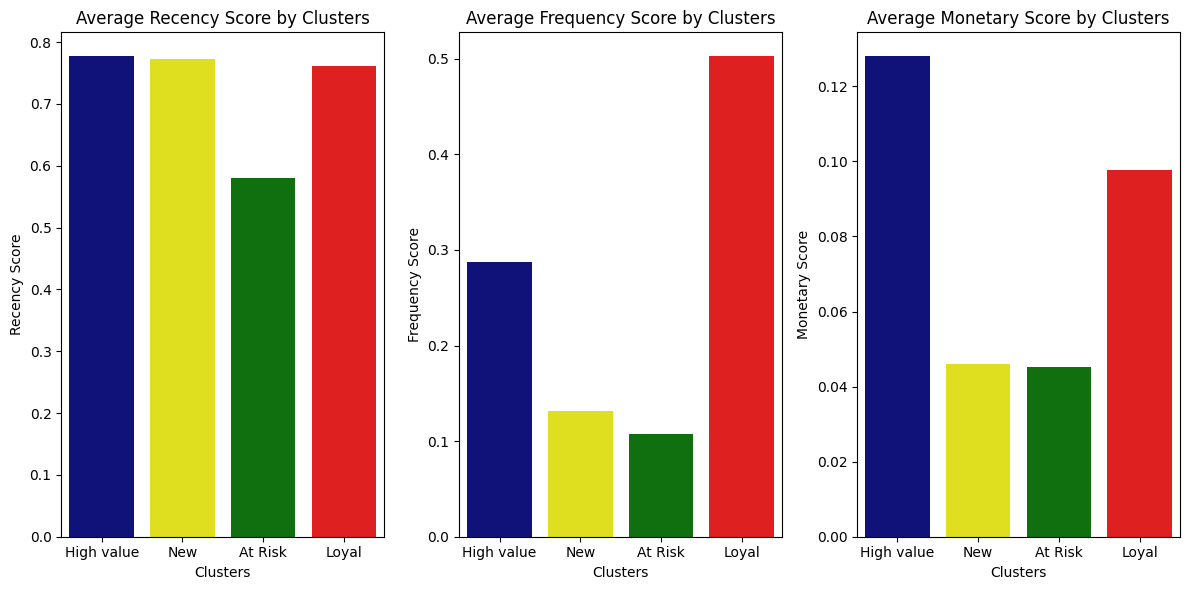

In [29]:
# Analyze cluster characteristics
cluster_analysis = merged_df_4.groupby('Cluster').agg({
    'scaled_latest_order_completed_minmax': 'mean',
    'scaled_num_transactions_minmax': 'mean',
    'scaled_size_of_transactions_minmax': 'mean',
    'Cluster': 'size'
}).rename(columns={'Cluster': 'Count'})


# Add labels to clusters
cluster_labels = {
    0: 'High value',
    1: 'New',
    2: 'At Risk',
    3: 'Loyal'
}
cluster_analysis['Clusters'] = cluster_analysis.index.map(cluster_labels)

# Define colors for clusters
cluster_colors = {
    'High value': 'darkblue',
    'New': 'yellow',
    'At Risk': 'green',
    'Loyal': 'red'
}

# Visualize cluster characteristics
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.barplot(data=cluster_analysis, x='Clusters', y='scaled_latest_order_completed_minmax', palette=cluster_colors)
plt.title('Average Recency Score by Clusters')
plt.ylabel('Recency Score')  

plt.subplot(1, 3, 2)
sns.barplot(data=cluster_analysis, x='Clusters', y='scaled_num_transactions_minmax', palette=cluster_colors)
plt.title('Average Frequency Score by Clusters')
plt.ylabel('Frequency Score')  

plt.subplot(1, 3, 3)
sns.barplot(data=cluster_analysis, x='Clusters', y='scaled_size_of_transactions_minmax', palette=cluster_colors)
plt.title('Average Monetary Score by Clusters')
plt.ylabel('Monetary Score')  

plt.tight_layout()
plt.show()

In [30]:

def generate_random_customer_id():
    # Get unique customer IDs from the dataframe
    customer_ids = merged_df_4['id'].unique()
    # Select a random customer ID from the list
    random_customer_id = random.choice(customer_ids)
    return random_customer_id

# Generate a random customer ID
random_customer_id = generate_random_customer_id()
print("Random Customer ID:", random_customer_id)

# Define a function to recommend an offer based on completion rates
def recommend_offer(customer_id):
    # Filter customer's data
    customer_data = merged_df_4[merged_df_4['id'] == customer_id]
    
    if customer_data.empty:
        return "Customer not found"
    
    # Calculate completion rates for each offer type (excluding informational)
    completion_rates = {}
    for offer_type in offer_received_counts.index:
        if offer_type != '3f207df678b143eea3cee63160fa8bed':  # Exclude informational offers
            offer_completed_count = customer_data[(customer_data['event'] == 'offer completed') & (customer_data['value'] == offer_type)].shape[0]
            offer_received_count = offer_received_counts[offer_type]
            if offer_received_count > 0:
                completion_rate = offer_completed_count / offer_received_count
            else:
                completion_rate = 0
            completion_rates[offer_type] = completion_rate
    
    # Select the offer type with the highest completion rate
    recommended_offer_type = max(completion_rates, key=completion_rates.get)
    
    # Retrieve offer details
    offer_details = merged_df_4.loc[merged_df_4['value'] == recommended_offer_type].iloc[0]
    
    # Extract relevant information
    reward = offer_details['reward']
    difficulty = offer_details['difficulty']
    duration = offer_details['duration']
    offer_type = offer_details['offer_type']
    
    # Return the recommended offer details
    return reward, difficulty, duration, offer_type

# Input: Customer ID
customer_id = input("Enter customer's ID: ")

# Generate recommendation based on customer's completion rates
recommended_reward, recommended_difficulty, recommended_duration, recommended_offer_type = recommend_offer(customer_id)
print("Recommended Offer Details:")
print("Offer Type:", recommended_offer_type)
print("Reward:", recommended_reward)
print("Difficulty:", recommended_difficulty)
print("Duration:", recommended_duration)


Random Customer ID: a8fcb3020d674e7087b4ab4a5088b391
Recommended Offer Details:
Offer Type: discount
Reward: 2.0
Difficulty: 10.0
Duration: 10.0
